In [19]:
# Prévision du chiffre d’affaires mensuel
# Dataset : sales_data_sample.csv
# Objectif : Analyse et prévision du chiffre d’affaires mensuel par magasin et produit

In [20]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

In [21]:
# 2) Chargement et nettoyage des données

# Créer les dossiers nécessaires s'ils n'existent pas
os.makedirs("../data/cleaned", exist_ok=True)
os.makedirs("../data/visuals", exist_ok=True)

df = pd.read_csv("../data/raw/sales_data_sample.csv",  encoding="latin1")

# Vérification rapide
df.info()
df.head()

# Vérifier les valeurs manquantes
print(df.isna().sum())

# Conversion de la colonne date en datetime
df.rename(columns={"ORDERDATE": "Date"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])

# Ajouter colonne TotalPrice si nécessaire (utiliser la colonne SALES existante ou calculer)
if "TotalPrice" not in df.columns:
    # Utiliser la colonne SALES si elle existe, sinon calculer
    if "SALES" in df.columns:
        df["TotalPrice"] = df["SALES"]
    else:
        df["TotalPrice"] = df["QUANTITYORDERED"] * df["PRICEEACH"]

# Ajouter colonnes Year, Month et Year-Month (utiliser "Date" avec majuscule)
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["YearMonth"] = df["Date"].dt.to_period("M")

# Sauvegarde dataset nettoyé
df.to_csv("../data/cleaned/sales_data_cleaned.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


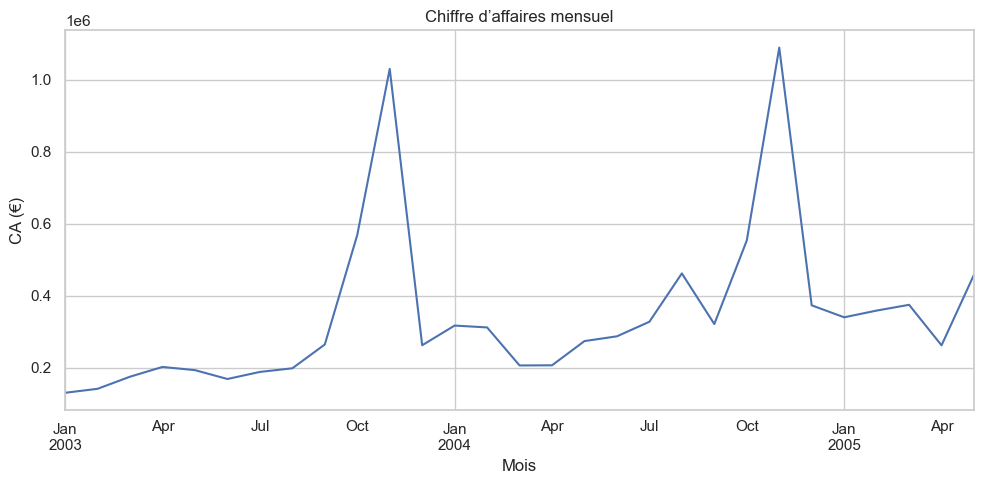

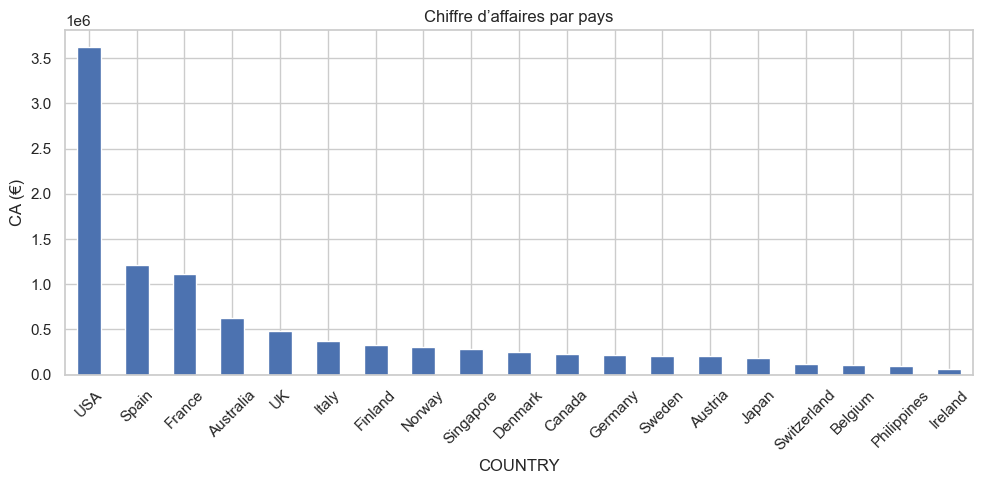

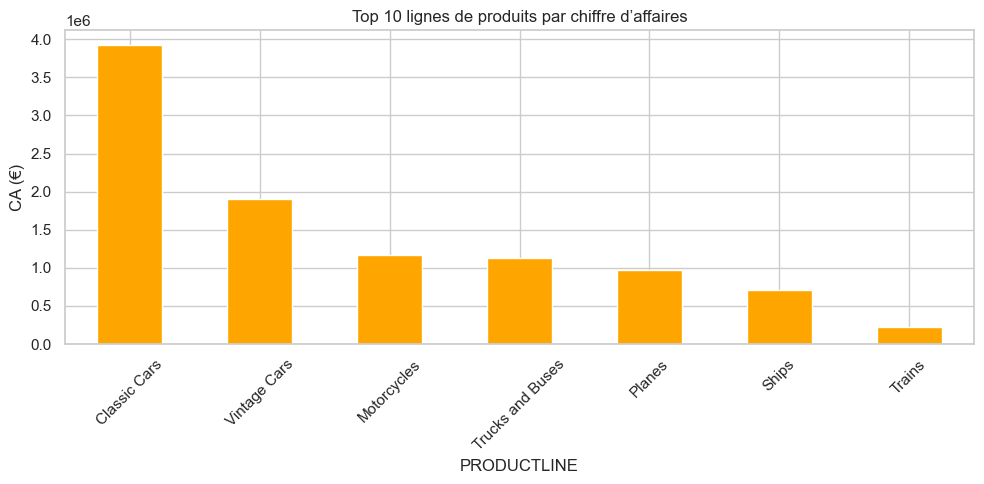

In [22]:
# 3) Analyse exploratoire

# a) CA total par mois
monthly_sales = df.groupby("YearMonth")["TotalPrice"].sum()
monthly_sales.plot(kind="line")
plt.title("Chiffre d’affaires mensuel")
plt.xlabel("Mois")
plt.ylabel("CA (€)")
plt.tight_layout()
plt.savefig("../data/visuals/monthly_sales.png")
plt.show()

# b) CA par pays (remplace "Store" par "COUNTRY")
country_sales = df.groupby("COUNTRY")["TotalPrice"].sum().sort_values(ascending=False)
country_sales.plot(kind="bar")
plt.title("Chiffre d’affaires par pays")
plt.ylabel("CA (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../data/visuals/country_sales.png")
plt.show()

# c) Top 10 produits (remplace "Item" par "PRODUCTLINE")
top_products = df.groupby("PRODUCTLINE")["TotalPrice"].sum().sort_values(ascending=False).head(10)
top_products.plot(kind="bar", color="orange")
plt.title("Top 10 lignes de produits par chiffre d’affaires")
plt.ylabel("CA (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../data/visuals/top_products.png")
plt.show()


In [23]:
# 4) Préparation pour prévision

# Agrégation CA par mois
ts = monthly_sales.reset_index()
ts["YearMonth"] = ts["YearMonth"].dt.to_timestamp()
ts = ts.rename(columns={"TotalPrice":"MonthlySales"})

# Split train/test (80% train, 20% test)
split_index = int(len(ts)*0.8)
train = ts.iloc[:split_index]
test = ts.iloc[split_index:]

X_train = np.arange(len(train)).reshape(-1,1)
y_train = train["MonthlySales"].values
X_test = np.arange(len(train), len(ts)).reshape(-1,1)
y_test = test["MonthlySales"].values

In [24]:
# 5) Modélisation – Régression linéaire simple
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

In [26]:
# 6) Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f}")
print(f"Nombre de points d'entraînement: {len(train)}")
print(f"Nombre de points de test: {len(test)}")

RMSE: 257772.96 | MAE: 250489.05
Nombre de points d'entraînement: 23
Nombre de points de test: 6


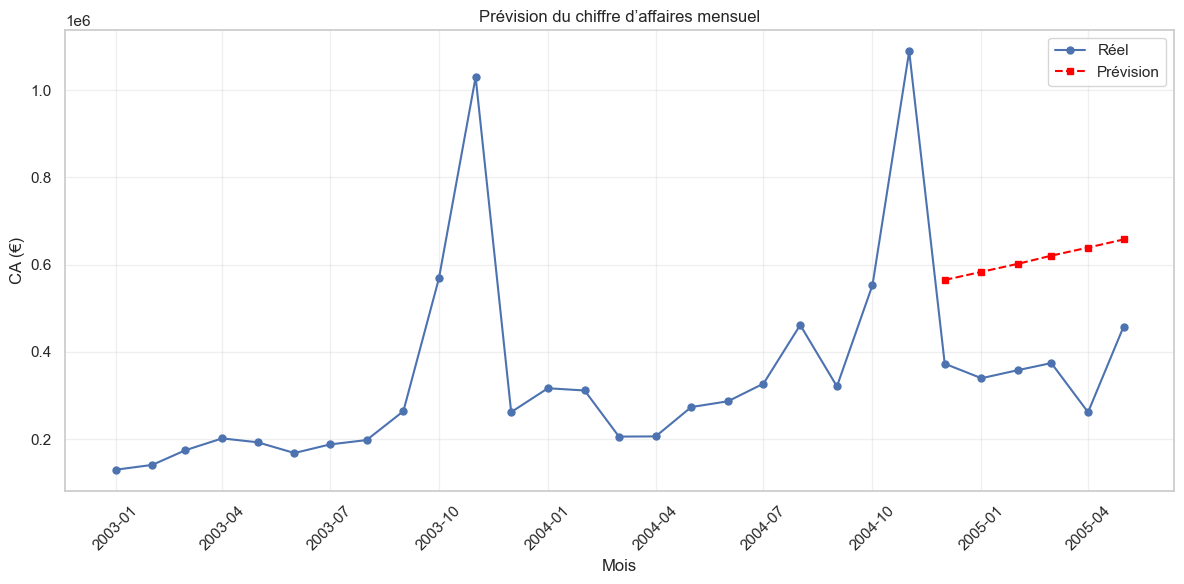

In [27]:
# 7) Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(ts["YearMonth"], ts["MonthlySales"], label="Réel", marker="o", markersize=5)
plt.plot(test["YearMonth"].values, y_pred, label="Prévision", linestyle="--", color="red", marker="s", markersize=5)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.title("Prévision du chiffre d’affaires mensuel")
plt.xlabel("Mois")
plt.ylabel("CA (€)")
plt.legend()
plt.tight_layout()
plt.savefig("../data/visuals/monthly_sales_forecast.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# 8) Insights
"""
💡 Insights possibles :
- Identifier les tendances saisonnières : pics à certaines périodes
- Les magasins les plus performants contribuent à la majorité du CA
- Les produits phares à mettre en avant dans les campagnes marketing
- Le modèle de régression linéaire simple montre la tendance globale, mais on pourrait améliorer avec Random Forest ou Prophet pour plus de précision
"""

'\n💡 Insights possibles :\n- Identifier les tendances saisonnières : pics à certaines périodes\n- Les magasins les plus performants contribuent à la majorité du CA\n- Les produits phares à mettre en avant dans les campagnes marketing\n- Le modèle de régression linéaire simple montre la tendance globale, mais on pourrait améliorer avec Random Forest ou Prophet pour plus de précision\n'